# Kaggle - How Much Did It Rain? II

Please download the following two files from Kaggle's [How Much Did It Rain? II](https://www.kaggle.com/c/how-much-did-it-rain-ii/) page. You will need to signup to a free Kaggle account if you don't have one yet.

The files you need are:

- train.zip
- test.zip

Kaggle's [description](https://www.kaggle.com/c/how-much-did-it-rain-ii/data) of the data:

> To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected'). That is why there are multiple rows with the same 'Id'.

The columns in the datasets are:

Column | Description
-----: | :----------
Id | A unique number for the set of observations over an hour at a gauge.
minutes_past | For each set of radar observations, the minutes past the top of the hour that the radar observations were carried out.  Radar observations are snapshots at that point in time.
radardist_km | Distance of gauge from the radar whose observations are being reported.
Ref | Radar reflectivity in km
Ref_5x5_10th | 10th percentile of reflectivity values in 5x5 neighborhood around the gauge.
Ref_5x5_50th | 50th percentile
Ref_5x5_90th | 90th percentile
RefComposite | Maximum reflectivity in the vertical column above gauge.  In dBZ.
RefComposite_5x5_10th |
RefComposite_5x5_50th |
RefComposite_5x5_90th |
RhoHV | Correlation coefficient (unitless)
RhoHV_5x5_10th |
RhoHV_5x5_50th |
RhoHV_5x5_90th |
Zdr | Differential reflectivity in dB
Zdr_5x5_10th |
Zdr_5x5_50th |
Zdr_5x5_90th |
Kdp | Specific differential phase (deg/km)
Kdp_5x5_10th |
Kdp_5x5_50th |
Kdp_5x5_90th |
Expected | Actual gauge observation in mm at the end of the hour.

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

from datetime import datetime

from tensorflow.contrib.rnn import GRUCell
from tensorflow.contrib.layers import batch_norm, fully_connected, variance_scaling_initializer
from tensorflow.contrib.learn import extract_pandas_data, extract_pandas_labels

from sklearn.preprocessing import MinMaxScaler, StandardScaler

The training and test data must exist before we can continue:

In [2]:
assert os.path.isfile('train.csv')

Import the training data:

In [3]:
df = pd.read_csv('train.csv')

Quickly have a look at the data:

In [4]:
df.head(18)  # The first 18 rows contain all measurements for Id's 1 and 2.

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
5,1,55,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
6,2,1,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
7,2,6,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
8,2,11,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016
9,2,16,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016


In [5]:
df.shape

(13765201, 24)

In [6]:
df.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,1.376520e+07,1.376520e+07,1.376520e+07,6.349375e+06,5.283988e+06,6.356482e+06,7.551281e+06,6.716343e+06,5.755673e+06,6.711663e+06,...,5.905584e+06,4.934916e+06,4.133154e+06,4.936568e+06,5.905584e+06,4.182635e+06,3.428782e+06,4.187281e+06,5.052776e+06,1.376520e+07
mean,5.923370e+05,2.952373e+01,1.106794e+01,2.292666e+01,1.995227e+01,2.261029e+01,2.589846e+01,2.471108e+01,2.215824e+01,2.442075e+01,...,1.015272e+00,5.367092e-01,-7.190076e-01,3.376216e-01,2.072870e+00,3.545172e-02,-3.482325e+00,-4.736553e-01,4.079836e+00,1.086263e+02
std,3.408561e+05,1.730813e+01,4.206618e+00,1.035516e+01,9.208166e+00,1.005300e+01,1.110958e+01,1.068962e+01,9.702705e+00,1.042453e+01,...,4.861606e-02,1.510399e+00,1.006068e+00,9.386440e-01,1.670194e+00,3.869725e+00,2.792120e+00,2.263046e+00,4.147337e+00,5.486058e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.100000e+01,-3.200000e+01,-3.200000e+01,-2.850000e+01,-3.200000e+01,-3.100000e+01,-2.750000e+01,...,2.083333e-01,-7.875000e+00,-7.875000e+00,-7.875000e+00,-7.875000e+00,-9.604000e+01,-8.079000e+01,-7.877000e+01,-1.002000e+02,1.000000e-02
25%,2.968970e+05,1.500000e+01,9.000000e+00,1.600000e+01,1.400000e+01,1.600000e+01,1.800000e+01,1.750000e+01,1.600000e+01,1.750000e+01,...,9.983333e-01,-1.875000e-01,-1.125000e+00,-6.250000e-02,1.062500e+00,-1.410004e+00,-4.580002e+00,-7.100067e-01,2.069992e+00,2.540001e-01
50%,5.921990e+05,3.000000e+01,1.100000e+01,2.250000e+01,2.000000e+01,2.250000e+01,2.550000e+01,2.400000e+01,2.200000e+01,2.400000e+01,...,1.011667e+00,3.750000e-01,-6.250000e-01,2.500000e-01,1.687500e+00,0.000000e+00,-2.820007e+00,0.000000e+00,3.519989e+00,1.016000e+00
75%,8.895820e+05,4.400000e+01,1.400000e+01,2.950000e+01,2.600000e+01,2.900000e+01,3.350000e+01,3.150000e+01,2.850000e+01,3.150000e+01,...,1.051667e+00,1.062500e+00,-1.875000e-01,6.875000e-01,2.625000e+00,1.750000e+00,-1.760010e+00,3.499908e-01,5.639999e+00,3.810002e+00
max,1.180945e+06,5.900000e+01,2.100000e+01,7.100000e+01,6.250000e+01,6.900000e+01,7.250000e+01,9.250000e+01,6.600000e+01,7.100000e+01,...,1.051667e+00,7.937500e+00,7.937500e+00,7.937500e+00,7.937500e+00,1.797500e+02,3.519989e+00,1.280000e+01,1.446000e+02,3.301773e+04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.5 GB


We have 24 columns, of which one is the Id of the group of measurements falling in the same hour, and one is the Exptected value. So in effect we are left with **22 features**.

Some of the values are presented in dBZ, a logarithmic scale, which is more difficult to learn than a linear scale. Let's transform these features to a linear scale. The [conversion formula](http://glossary.ametsoc.org/wiki/Dbz) is:

\begin{equation*}
Z_{dBZ} = 10 \log_{10} Z
\end{equation*}

This gives:

\begin{equation*}
Z = 10^{\frac{Z_{dBZ}}{10}}
\end{equation*}

The linear $Z$ has unit $\frac{mm^6}{m^3}$.

We can scale the **RefComposite** columns. These may tell us something about the amount of rain:

In [9]:
for column in 'RefComposite', 'RefComposite_5x5_10th', 'RefComposite_5x5_50th', 'RefComposite_5x5_90th':
    df[column] = 10 ** (df[column] / 10.0)

We can also scale the **Zdr** columns. These tell us something about the shape of the rain drops:

In [11]:
for column in 'Zdr', 'Zdr_5x5_10th', 'Zdr_5x5_50th', 'Zdr_5x5_90th':
    df[column] = 10 ** (df[column] / 10.0)

We can also add a new feature, which is already an estimate of the amount of rain that will fall. This is given by [the Marshall-Palmer relation](http://glossary.ametsoc.org/wiki/Marshall-palmer_relation).

Its formula is, given the linear $Z$ we calculated from **RefComposite** earlier:

\begin{equation*}
Z = 200 R^{1.6}
\end{equation*}

This gives:

\begin{equation}
R = \sqrt[1.6]{\frac{Z}{200}}
\end{equation}

Or equivalent:

\begin{equation}
R = (\frac{Z}{200})^{0.625}
\end{equation}


Here $R$ is the rainfall rate and has unit $\frac{mm}{hour}$.

In [14]:
for a, b in [('RefComposite', 'R'),
             ('RefComposite_5x5_10th', 'R_5x5_10th'),
             ('RefComposite_5x5_50th', 'R_5x5_50th'),
             ('RefComposite_5x5_90th', 'R_5x5_90th')]:
    df[b] = np.power(df[a] / 200.0, 0.625)

Let's first train on a subset of the training data, to see whether the network converges. The rows up to and including #1044 contain the first 100 sequences:

In [17]:
df = df[:1044]

## Frame the problem

From Kaggle:

> You are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total.

So we have a **regression** problem here, a **multivariate** one at that, since we have more than one input.

> To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected').

It is a **supervised learning** task, since the _target_ or _label_ is provided for us. And since each instance consists of multiple observations over the course of an hour, each instance is a time series and drives us to looking into Recurrent Neural Networks (RNN).

> The evaluation metric for this competition is Mean Absolute Error (MAE)

Ok, that's a given. The MAE is defined as:

\begin{equation*}
MAE = \frac{1}{m} \sum_{i=1}^{m} \vert y_{i} - \hat{y_{i}} \vert
\end{equation*}

Note:

> A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example)

We'll have to see whether we can leave these values in or whether we'll have to first find a way to filter them out.

## Visualize the data

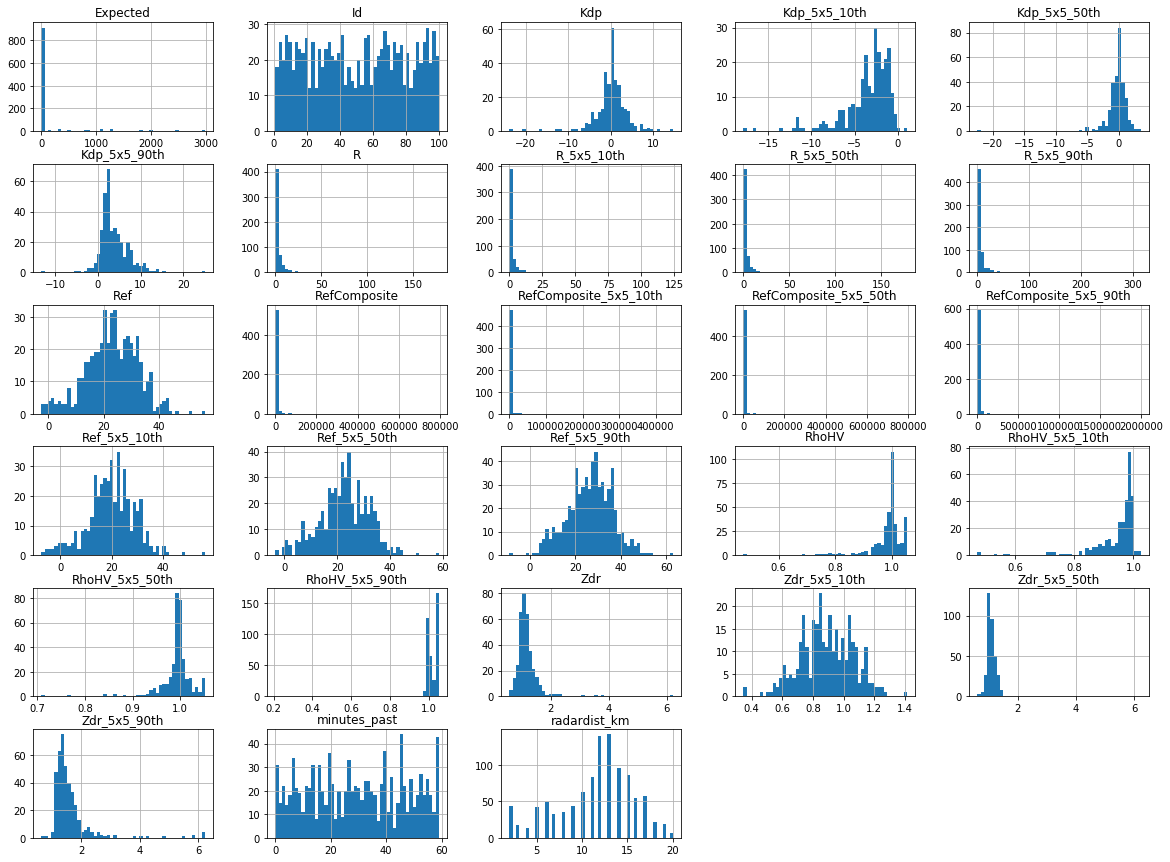

In [18]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

## Prepare the data

The distribution of expected rain in milimeters seems off, as warned about. The maximum value of about 30,000 millimeters means that _30 meters_ of rain would have fallen in that hour. Better call Noah to build us a boat...

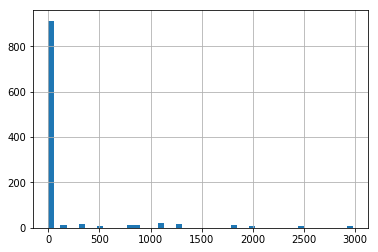

In [19]:
df['Expected'].hist(bins=50)
plt.show()

Since there are multiple radar observations per hour, and all of these have the same values for Id and Expected, we can first simplify the histogram by taking only the first Expected value (`head(1)`) per Id (`groupby('Id')`) into account. That is what we do here:

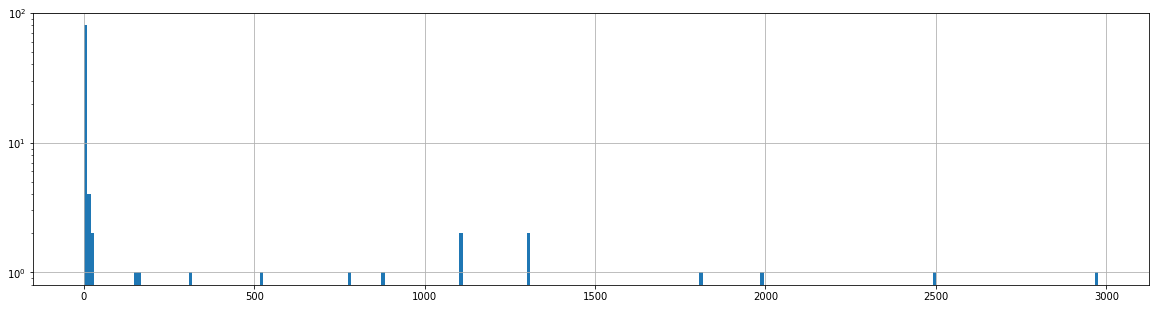

In [20]:
# Plot it logarithmically so that we can still make out Expected values
# that do not occur that often.
_, ax = plt.subplots()
df.groupby('Id').head(1)['Expected'].hist(ax=ax, bins=300,figsize=(20,5))
ax.set_yscale('log')
plt.show()

We can see that the largest peak in expected rain is close to zero mm's, and that the majority of rain is less than 5,000 mm per hour. This is still five meters of rain, but maybe that's realistic, I have no idea.

This is followed by some lone wolves of more than 5,000 mm of rain per hour. Since these values are so dispersed over the range, it is likely these our outliers caused by clogged gauges, and we can simply discard these measurements.

In [21]:
df = df[df['Expected'] < 5000]

Some cells have no values ("NaN", or Not a Number). There are [various ways](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) we can handle missing data.

The simplest thing to do would be to discard instances containing one or more of such cells, but if there are quite many of them, then maybe we want to keep them but replace them by, for instance, the median across all those cells.

How many rows have at least one NaN?

In [22]:
df.isnull().any(axis=1).sum()

812

Let's simply replace such NaN values by the **mean** of their columns:

In [23]:
df = df.fillna(df.mean())

## Feature Scaling

Let's look at the spread of the features we have:

In [24]:
for column in df.columns.difference(['Id', 'Expected']):
    print('{:<25}  {:8.3f}  {:8.3f}'.format(
        column,
        df[column].min(),
        df[column].max()))

Kdp                         -23.870    14.620
Kdp_5x5_10th                -17.910     1.060
Kdp_5x5_50th                -22.460     3.510
Kdp_5x5_90th                -13.230    25.050
R                             0.021   177.565
R_5x5_10th                    0.019   123.910
R_5x5_50th                    0.024   177.565
R_5x5_90th                    0.034   315.759
Ref                          -2.500    56.500
RefComposite                  0.398  794328.235
RefComposite_5x5_10th         0.355  446683.592
RefComposite_5x5_50th         0.501  794328.235
RefComposite_5x5_90th         0.891  1995262.315
Ref_5x5_10th                 -7.500    56.500
Ref_5x5_50th                 -3.500    58.500
Ref_5x5_90th                 -9.000    63.000
RhoHV                         0.475     1.052
RhoHV_5x5_10th                0.472     1.025
RhoHV_5x5_50th                0.708     1.052
RhoHV_5x5_90th                0.208     1.052
Zdr                           0.562     6.219
Zdr_5x5_10th             

They are all over the place. Let's scale them:

In [25]:
columns_to_scale = df.columns.difference(['Id', 'Expected'])
df[columns_to_scale] = StandardScaler().fit_transform(df[columns_to_scale])

Did it work?

In [26]:
for column in columns_to_scale:
    print('{:<25}  {:8.3f}  {:8.3f}'.format(
        column,
        df[column].min(),
        df[column].max()))

Kdp                         -11.941     7.237
Kdp_5x5_10th                -10.431     3.279
Kdp_5x5_50th                -22.993     3.803
Kdp_5x5_90th                 -8.670    10.839
R                            -0.509    24.871
R_5x5_10th                   -0.485    25.638
R_5x5_50th                   -0.480    25.186
R_5x5_90th                   -0.481    24.977
Ref                          -3.940     5.172
RefComposite                 -0.166    30.324
RefComposite_5x5_10th        -0.159    30.061
RefComposite_5x5_50th        -0.153    29.986
RefComposite_5x5_90th        -0.151    30.496
Ref_5x5_10th                 -4.695     6.303
Ref_5x5_50th                 -4.050     5.577
Ref_5x5_90th                 -4.798     4.946
RhoHV                       -14.793     1.908
RhoHV_5x5_10th              -11.052     1.874
RhoHV_5x5_50th              -14.350     2.990
RhoHV_5x5_90th              -26.356     1.065
Zdr                          -2.460    19.832
Zdr_5x5_10th                 -5.85

## Sequence Length

Remember that radar measurements are taken a number of times per hour, and all these together carry the same Id. One such group makes up a **time-series** for our recurrent network.

Let's look at the distribution of the lenghts of these time series:

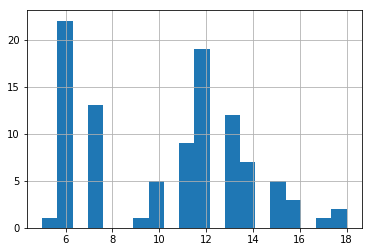

In [27]:
group_sizes = df.groupby('Id').size()
group_sizes.hist(bins=20)

In [28]:
group_sizes.min(), group_sizes.max()

(5, 18)

So some hourly groups consist of only one sample, and some as many as 19. This means our time series will be of variable length and we'll have to take care of this.

## Batching Pandas DataFrame into TensorFlow

All training and test data is contained in a Pandas DataFrame referenced by `df`. To train our model in TensorFlow, we'll have to extract the features (aka _predictors_ or simply the columns) as well as the labels (or _targets_).

In [29]:
class Sequence:
    def __init__(self, first_row, last_row=None):
        self.first_row = first_row
        self.last_row  = first_row if last_row is None else last_row
    
    def length(self):
        return self.last_row - self.first_row + 1
    
class Batcher:
    def __init__(self, df, batch_size=50):
        self._df                  = df
        self._batch_size          = batch_size
        self._sequences           = self.group_measurements()
        self._sequence_order      = list(self._sequences.keys())
        self._curr_sequence_index = 0
        self._max_sequence_length = self.max_sequence_length()
        
        self.reset()

    def max_sequence_length(self):
        seq = max(list(self._sequences.values()), key=lambda x: x.length())
        return seq.length()

    def feature_count(self):
        (_rows, columns) = df.shape
        return columns - 2  # Id and Expected are no features.

    def group_measurements(self):
        d = dict()
        for idx, group_id in df['Id'].iteritems():
            if not group_id in d.keys():
                d[group_id] = Sequence(first_row=idx)
            else:
                d[group_id].last_row = idx
        return d

    def reset(self):
        """Shuffles all sequences and starts over."""
        random.shuffle(self._sequence_order)
        self._curr_sequence_index = 0

    def next_batch(self):
        """Returns a (lengths, sequences, labels) tuple where each item is of
        length batch_size and lengths[i] indicates the effective length of
        sequences[i] (the remainder being zeros), and labels[i] is the sequence's
        target value."""
        
        lengths, sequences, labels = [], [], []
        
        n_sequences_left = len(self._sequences) - self._curr_sequence_index
        for i in range(min(self._batch_size, n_sequences_left)):
            s = self._sequences[self._sequence_order[self._curr_sequence_index]]
            self._curr_sequence_index += 1
            
            rows     = df.loc[s.first_row:s.last_row]
            sequence = np.asmatrix(rows[rows.columns.difference(['Id', 'Expected'])])
            label    = rows['Expected'].iloc[0]  # All rows have the same label.

            # This sequence may be shorter than the maximum, so extend it with zeros
            # to ensure all sequences are of equal length.
            length = s.length()
            if length < self._max_sequence_length:
                m = self._max_sequence_length - length
                n = self.feature_count()
                sequence = np.append(sequence, np.zeros((m, n)), axis=0)
            
            lengths.append(length)
            sequences.append(sequence)
            labels.append(label)

        return lengths, sequences, labels
    
    def batch_count(self):
        """Returns the total number of batches. The final batch may be smaller."""
        return math.ceil(len(self._sequences) / self._batch_size)

## Build a First Model

Create a batcher only once, since it's expensive:

In [30]:
batcher = Batcher(df)

Define some constants:

In [31]:
n_steps   = batcher.max_sequence_length()   # Longest input sequence is 19 measurements in one hour.
n_inputs  = batcher.feature_count()         # Data consists of 22 features.
n_neurons = (300, 100)                      # Have to start somewhere.
n_outputs = 1                               # Regression task: predict fallen rain in mm.

Build the network:

In [32]:
tf.reset_default_graph()

X          = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs], name='X')
y          = tf.placeholder(tf.float32, shape=[None],                    name='y')
seq_length = tf.placeholder(tf.int32,   shape=[None],                    name='seq_length')

is_training = tf.placeholder(tf.bool, [], name='is_training')
batch_norm_params = {
    'is_training': is_training,
    'decay': 0.99,
    'updates_collections': None
}

# Use He-initialization for the weights to prevent vanishing/exploding gradients.
he_init = variance_scaling_initializer()

# The core the network is a set of Gated Recurrent Unit (GRU) cells, a simpler but
# equally efficient variant of the Long Short-Term Memory (LSTM) cell. We're using
# two layers of them.
with tf.variable_scope('layer1'):
    cell1                 = GRUCell(num_units=n_neurons[0], kernel_initializer=he_init, activation=tf.nn.relu)
    rnn_outputs1, states1 = tf.nn.dynamic_rnn(cell1, X, dtype=tf.float32, sequence_length=seq_length)

# TODO: Do I need to use batch normalization here too?
with tf.variable_scope('layer2'):
    cell2                 = GRUCell(num_units=n_neurons[1], kernel_initializer=he_init, activation=tf.nn.relu)
    rnn_outputs2, states2 = tf.nn.dynamic_rnn(cell2, rnn_outputs1, dtype=tf.float32, sequence_length=seq_length)

# The GRU cell has #n_neurons outputs, and we need to map these onto one output for
# our regression problem, to predict the amount of fallen rain. We use a fully connected
# layer to do so. We do *not* predict a time series, so we're only interested in the
# final state (in 'states') of the RNN after it has been fed an input sequence.
outputs = fully_connected(
    states2,
    n_outputs,
    normalizer_fn=batch_norm,
    normalizer_params=batch_norm_params,
    activation_fn=None)

learning_rate = 0.001

# The loss function is the requested Mean Absolute Error (MAE).
error       = outputs - y
mae         = tf.reduce_mean(tf.abs(error), name='mae')
optimizer   = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mae)

init = tf.global_variables_initializer()

Ensure we can visualize in TensorBoard:

In [33]:
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now)

mae_summary = tf.summary.scalar('MAE', mae)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Let's run the model:

In [34]:
n_epochs  = 2000
n_batches = batcher.batch_count()
print('#batches:', n_batches)
assert n_batches > 0

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        print("\repoch {}/{}".format(epoch+1, n_epochs), end='')

        batcher.reset()
        for iteration in range(n_batches):
            seq_length_batch, X_batch, y_batch = batcher.next_batch()
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, seq_length: seq_length_batch, is_training: True})
            if iteration % 10 == 0:
                summary_str = mae_summary.eval(feed_dict={X: X_batch, y: y_batch, seq_length: seq_length_batch, is_training: False})
                step = epoch * n_batches + iteration
                file_writer.add_summary(summary_str, step)
    
    print("\r\nFinal MAE:", mae.eval(feed_dict={X: X_batch, y: y_batch, seq_length: seq_length_batch, is_training: False}))

#batches: 2
epoch 2000/2000
Final MAE: 151.65


In [35]:
file_writer.close()